# Model training dataset creation

This notebook implements training dataset creation tools for implementing a NN based receiver, which plugs in the DFT output and returns the bits (probabilities), and hence replaces the channel estimation, equalization and demapper functionalities entirely. (refer to https://arxiv.org/abs/2005.01494 for more) 

In [1]:
from config import *
from OFDM_SDR_Functions_torch import *
import torch
from torch.utils.data import Dataset
import numpy as np
import random

Create the modulation mapping and demapping tables, the TTI mask and place the pilot symbols in the mask.

In [2]:
mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=False) # mapping table for Qm

TTI_mask_RE = TTI_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotTTI=False) # TTI mask
pilot_symbols = pilot_set(TTI_mask_RE, Pilot_Power) # pilot symbols

Create the bitstream and modulate it. Place the modulated symbols in the TTI, do the FFT and add cyclic prefix.

In [3]:
def create_OFDM_data():
    pdsch_bits, pdsch_symbols  = create_PDSCH_data(TTI_mask_RE, Qm, mapping_table_Qm, power=PDSCH_power) # PDSCH data bits stream, modulated symbols
    Modulated_TTI = RE_mapping(TTI_mask_RE, pilot_symbols, pdsch_symbols, plotTTI=False) # TTI with pilot and PDSCH symbols
    TD_TTI_IQ = FFT(Modulated_TTI) # TTI in time domain
    TX_Samples = CP_addition(TD_TTI_IQ, S, FFT_size, CP) # TTI with cyclic prefix
    return pdsch_bits, TX_Samples 

Make a custom torch dataset. The structure of the dataset is defined in the config file.

In [4]:
dataset = CustomDataset()

Create a loop to make data for the dataset, and finally save it. To speed the process up, instead of using the SDR for radio channels creation, the implemented simple CDL-C radio channel model is used instead. The dataset is not shared in this repository due to it being easily very large. You can easily create your own.

In [5]:
number_of_training_items = 10000

ch_SINR_min = 25 # channel emulation min SINR
ch_SINR_max = 50 # channel emulation max SINR

for i in range(number_of_training_items):
    if i % 1000 == 0:
        print(i)
    ch_SINR = int(random.uniform(ch_SINR_min, ch_SINR_max)) # SINR generation for adding noise to the channel
    pdsch_bits, TX_Samples = create_OFDM_data() # data stream

    # Radio channel
    RX_Samples = generate_cdl_c_impulse_response(tx_signal = TX_Samples, num_samples=100, sampling_rate=SampleRate, SINR=ch_SINR, repeats = 3, random_start=True, padding=500) # convolve channel with tx signal
    symbol_index=sync_TTI(TX_Samples, RX_Samples, 0) # find the starting symbol of the TTI from the received signal
    
    # receiver
    RX_NO_CP = CP_removal(RX_Samples, symbol_index, S, FFT_size, CP, plotsig=False) # remove cyclic prefix
    RX_NO_CP = RX_NO_CP / torch.max(torch.abs(RX_NO_CP)) # normalize
    OFDM_demod = DFT(RX_NO_CP, plotDFT=False) # DFT
    OFDM_demod = OFDM_demod / torch.max(torch.abs(OFDM_demod)) # normalize DFT'd signal for NN input

    # create pilot matrix as in the TTI mask
    z, pilot_symbols_map = get_pilot_symbols_raw(TTI_mask_RE, OFDM_demod) # get pilot symbols
    pilot_symbols_map = remove_fft_Offests(pilot_symbols_map, F, FFT_offset) # remove FFT offsets
    pilot_symbols_map = torch.cat((pilot_symbols_map[:, :F//2], pilot_symbols_map[:, F//2 + 1:]), dim=1)# remove DC
    
    # create PDSCH matrix, the same shape
    z2, pdsch_symbols_map = get_payload_symbols_raw(TTI_mask_RE, OFDM_demod) # get PDSCH symbols
    pdsch_symbols_map = remove_fft_Offests(pdsch_symbols_map, F, FFT_offset) # remove FFT offsets
    pdsch_symbols_map = torch.cat((pdsch_symbols_map[:, :F//2], pdsch_symbols_map[:, F//2 + 1:]), dim=1) # remove DC

    # create a bit stream matrix, again, the same shape
    TTI_mask_indices = torch.where(TTI_mask_RE==1)
    TTI_3d = torch.zeros((TTI_mask_RE.shape[0], TTI_mask_RE.shape[1], pdsch_bits.shape[1]), dtype=pdsch_bits.dtype)
    row_indices, col_indices = TTI_mask_indices
    
    TTI_3d[row_indices, col_indices, :] = pdsch_bits.clone().detach()
    TTI_3d = remove_fft_Offests(TTI_3d, F, FFT_offset)
    TTI_3d = torch.cat((TTI_3d[:, :F//2,:], TTI_3d[:, F//2 + 1:,:]), dim=1)  # remove DC
    
    dataset.add_item(pdsch_symbols_map, pilot_symbols_map, TTI_3d) # add to dataset
    
torch.save(dataset, 'data/ofdm_dataset.pth') # save dataset on disk
    

0


/home/riku/projects_mac/ofdm-plutosdr-pytorch/OFDM_SDR_Functions_torch.py:471: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tx_signal = torch.tensor(tx_signal, dtype=torch.complex64)
/home/riku/projects_mac/ofdm-plutosdr-pytorch/OFDM_SDR_Functions_torch.py:507: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise = torch.sqrt(torch.tensor(noise_power / 2)) * (torch.randn_like(convolved_signal) + 1j * torch.randn_like(convolved_signal))


1000
2000
3000
4000
5000
6000
7000
8000
9000


Check the shape of the training data inputs (data symbols, pilot symbols) and labels (bits). First two dimensions refer to number of symbols, and subcarriers correspondingly. The third dimension in the labels is the number of bits per symbol. E.g. 6 is 64QAM.

In [6]:
# print the last item in the dataset
print(f'Shape of the received symbols tensor: {dataset.pdsch_iq[-1].shape}, pilots tensor {dataset.pilot_iq[-1].shape}, and original modulated bits tensor {dataset.labels[-1].shape}') 

Shape of the received symbols tensor: torch.Size([14, 71]), pilots tensor torch.Size([14, 71]), and original modulated bits tensor torch.Size([14, 71, 4])


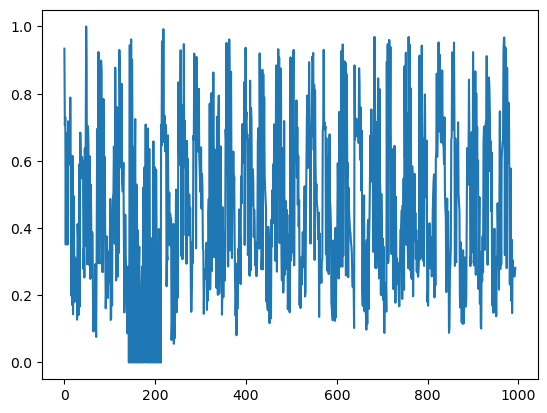

In [7]:
plt.plot(np.abs(dataset.pdsch_iq[-1].flatten().numpy()))

Text(0.5, 1.0, 'Received Symbols after DFT')

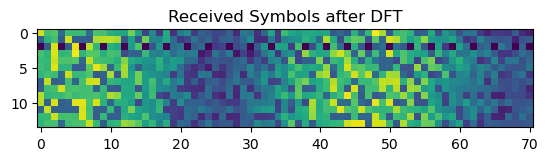

In [8]:
plt.imshow(np.abs(dataset.pdsch_iq[-1].numpy()))
plt.title('Received Symbols after DFT')

`Shape of the received symbols tensor: torch.Size([14, 72]), pilots tensor torch.Size([14, 72]), and original modulated bits tensor torch.Size([14, 72, 6])`

Text(0.5, 1.0, 'Pilot Symbols after DFT')

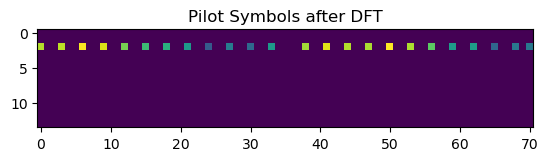

In [9]:
plt.imshow(np.abs(dataset.pilot_iq[-1].numpy()))
plt.title('Pilot Symbols after DFT')


Number of bits per symbol: 4


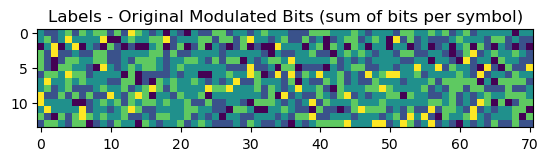

In [10]:
color_values = dataset.labels[-1].sum(dim=-1)
plt.imshow(color_values)
plt.title('Labels - Original Modulated Bits (sum of bits per symbol)')
print(f'Number of bits per symbol: {dataset.labels[-1].shape[-1]}')